In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init
from torchsummary import summary

# Data

In [27]:
#Load CFashionMIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='Data',
                                             train=True,
                                             download=True,
                                             transform= transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1024,
                                          num_workers=10,
                                          shuffle = True,
                                          drop_last = True)

testset = torchvision.datasets.FashionMNIST(root='Data',
                                            train=False,
                                            download=True,
                                            transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         num_workers=10,
                                         shuffle = False)

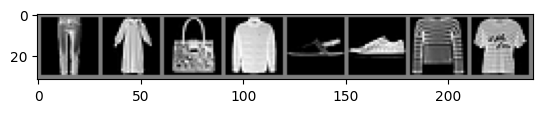

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

# Model

In [29]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=7)
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=7)
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=7)
        self.conv4 = nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=7)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(4*4*256, 128)
        self.dense2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)

        return x

In [30]:
#Load CFashionMIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='Data',
                                             train=True,
                                             download=True,
                                             transform= transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1024,
                                          num_workers=10,
                                          shuffle = True,
                                          drop_last = True)

testset = torchvision.datasets.FashionMNIST(root='Data',
                                            train=False,
                                            download=True,
                                            transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         num_workers=10,
                                         shuffle = False)

In [31]:
model = CustomModel()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 22, 22]           1,600
              ReLU-2           [-1, 32, 22, 22]               0
            Conv2d-3           [-1, 64, 16, 16]         100,416
              ReLU-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 10, 10]         401,536
              ReLU-6          [-1, 128, 10, 10]               0
            Conv2d-7            [-1, 256, 4, 4]       1,605,888
              ReLU-8            [-1, 256, 4, 4]               0
           Flatten-9                 [-1, 4096]               0
           Linear-10                  [-1, 128]         524,416
           Linear-11                   [-1, 10]           1,290
Total params: 2,635,146
Trainable params: 2,635,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

# Loss, Optimizer and Evaluate Function

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=1e-5)

In [33]:
def evalute(model, testloader, loss_fn):
    model.eval()
    test_loss = 0.0
    running_correct = 0.0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
    
    accuracy = running_correct *100 / total
    loss = test_loss / len(testloader)
    return loss, accuracy

# Train

In [34]:
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

max_epoch = 20

In [35]:
for epoch in  range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    for i, (images, labels ) in enumerate(trainloader, 0):

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_accuracy = running_correct * 100 / total
    epoch_loss = running_loss / (i+1)
    train_accuracies.append(epoch_accuracy)
    train_losses.append(epoch_loss)

    test_loss, test_accuracy = evalute(model, testloader, loss_fn)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/20], Loss: 2.1780, Accuracy: 34.37%, Test Loss: 1.8546, Test Accuracy: 42.61%
Epoch [2/20], Loss: 1.3404, Accuracy: 55.50%, Test Loss: 1.0209, Test Accuracy: 63.68%
Epoch [3/20], Loss: 0.9235, Accuracy: 66.09%, Test Loss: 0.8786, Test Accuracy: 67.80%
Epoch [4/20], Loss: 0.8308, Accuracy: 69.57%, Test Loss: 0.8136, Test Accuracy: 70.38%
Epoch [5/20], Loss: 0.7750, Accuracy: 71.58%, Test Loss: 0.7702, Test Accuracy: 71.56%
Epoch [6/20], Loss: 0.7330, Accuracy: 72.94%, Test Loss: 0.7363, Test Accuracy: 72.68%
Epoch [7/20], Loss: 0.7011, Accuracy: 73.97%, Test Loss: 0.7059, Test Accuracy: 73.77%
Epoch [8/20], Loss: 0.6741, Accuracy: 74.80%, Test Loss: 0.6861, Test Accuracy: 74.34%
Epoch [9/20], Loss: 0.6544, Accuracy: 75.31%, Test Loss: 0.6657, Test Accuracy: 75.01%
Epoch [10/20], Loss: 0.6367, Accuracy: 75.96%, Test Loss: 0.6496, Test Accuracy: 75.58%
Epoch [11/20], Loss: 0.6233, Accuracy: 76.25%, Test Loss: 0.6360, Test Accuracy: 75.95%
Epoch [12/20], Loss: 0.6117, Accuracy: 76

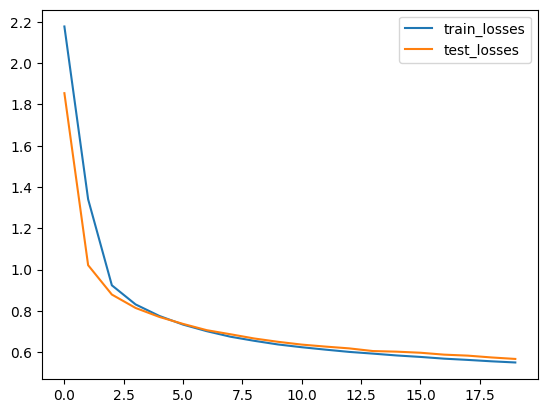

In [36]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

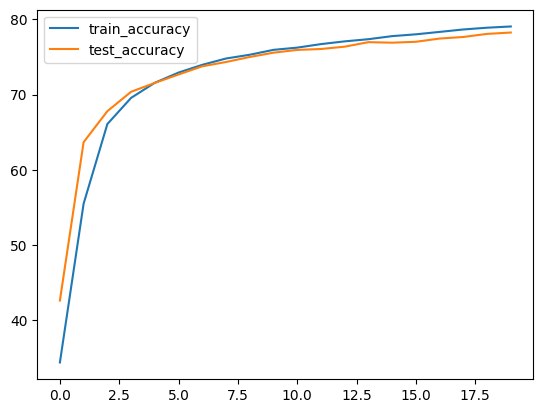

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()